# Load data train

In [ ]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pickle

from networkx.classes import neighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, silhouette_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.cluster import DBSCAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
def load_features_train():
    with open(r"/content/drive/Shared drives/Clustering Hackaton/features.pkl", "rb") as archivo:
        feature_vectors_f = pickle.load(archivo)
        video_ids_f = pickle.load(archivo)
    return feature_vectors_f, video_ids_f

train_feature_vectors, train_video_ids = load_features_train()

In [ ]:
!pip install umap-learn

In [ ]:
import umap
import numpy as np

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

In [ ]:
feature_vectors, video_ids = load_features_train()

In [ ]:

# Simplify the data using the mean
X = []
for feature_vector in feature_vectors:
    try:
        X.append(np.mean(feature_vector, axis=0))
    except:
        print("Error")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Remove nan values
for i in range(len(X)):
    if np.isnan(X[i]).any():
        X.pop(i)
        video_ids.pop(i)

In [ ]:
X = np.array(X)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=130)
pca.fit(X)
X_pca = pca.transform(X)
print(X_pca.shape)

(10694, 130)


# Get labels train

In [ ]:
# get labels from train_subset.csv which contains the id and label of the videos
train_subset_labels = pd.read_csv("/content/drive/Shared drives/Clustering Hackaton/train_subset.csv")
# select the labels that are in video_ids
train_subset_labels = train_subset_labels[train_subset_labels["youtube_id"].isin(video_ids)]

train_subset_labels

,youtube_id,label
0,GcTww0NOCk0,hopscotch
1,zeIkGEHK46I,riding camel
2,-Fwy8NwefTk,shot put
3,YYgESo5eQD8,situp
4,38Ml6v4vPzY,playing clarinet
...,...,...
10712,M0O8lByHQ-k,hopscotch
10713,XhZTEPRW5lk,shot put
10714,egfzXatr0jc,playing clarinet
10715,mQ0-F4Y24xo,playing ice hockey


In [ ]:
tunique=train_subset_labels["label"].unique()
print(len(tunique))

20


In [ ]:
Y_train = []
# sort the labels to have the same order as in the feature vectors and video_ids
for video_id in video_ids:
    sort_label = train_subset_labels[train_subset_labels["youtube_id"] == video_id]["label"].values[0]
    Y_train.append(sort_label)

In [ ]:
labels_map=sort_label
labels_map
Y_train

['balloon blowing',
 'balloon blowing',
 'cooking chicken',
 'baking cookies',
 'golf driving',
 'baking cookies',
 'balloon blowing',
 'shot put',
 'flipping pancake',
 'flipping pancake',
 'riding camel',
 'riding camel',
 'wrapping present',
 'riding camel',
 'cooking chicken',
 'flipping pancake',
 'flipping pancake',
 'shot put',
 'shot put',
 'hopscotch',
 'playing clarinet',
 'cooking chicken',
 'golf driving',
 'playing clarinet',
 'playing ice hockey',
 'riding camel',
 'golf driving',
 'cooking chicken',
 'riding camel',
 'balloon blowing',
 'stretching leg',
 'shot put',
 'stretching leg',
 'cooking chicken',
 'flipping pancake',
 'flipping pancake',
 'hopscotch',
 'balloon blowing',
 'stretching leg',
 'stretching leg',
 'wrapping present',
 'shot put',
 'riding camel',
 'playing ice hockey',
 'hopscotch',
 'wrapping present',
 'cooking chicken',
 'shot put',
 'shot put',
 'playing ice hockey',
 'playing clarinet',
 'flipping pancake',
 'riding camel',
 'texting',
 'playing

In [ ]:
#%%
# encode the lables to numbers
labelEncoder = LabelEncoder()
Y_train = labelEncoder.fit_transform(Y_train)

In [ ]:
print(Y_train.shape)

(10694,)


# Load data test

In [ ]:
def load_features_test():
    with open("/content/drive/Shared drives/Clustering Hackaton/features_test.pkl", "rb") as archivo:
        feature_vectors_test_f = pickle.load(archivo)
        video_ids_test_f = pickle.load(archivo)
    return feature_vectors_test_f, video_ids_test_f

In [ ]:
#%%
feature_vectors_test, video_ids_test = load_features_test()

In [ ]:
X_test = []
for feature_vector in feature_vectors_test:
    try:
        X_test.append(np.mean(feature_vector, axis=0))
    except:
        print("Error")

In [ ]:
for i in range(len(X_test)):
    if np.isnan(X_test[i]).any():
        X_test.pop(i)
        video_ids_test.pop(i)

In [ ]:
X_test = np.array(X_test)
print(X_test.shape)
print(len(video_ids_test))

(1626, 512)
1626


# **K-Means ++**

In [ ]:
import random

In [ ]:
class k_means_c:

  def __init__(self, k_, X_):
    self.k = k_
     #X es el conjunto de feature vectors de dimension d
    self.X = X_
    self.d = self.X.shape[1]
    self.n = self.X.shape[0]
    self.labels_map=labels_map
    self.centroides=None


  def aux_dist_eucl(self, xi, xj):
    sum = 0
    #agilizando con multiplicación de matrices
    xi_ = np.array(xi)
    xj_ = np.array(xj)
    sum += np.sum(np.dot((xi_ - xj_), (xi_ - xj_).T))
    return np.sqrt(sum) #distancia eucli


#Usa KMeans++ para mejorar la probabilidad de que los centroides estén bien separados
  def fcentroides(self, X):
    #1. selecciono solo 1 punto-centroide de manera random
    punto_inicial=self.X[random.randint(0,self.n-1)]

    distances=[]
    #recorro todos los X
    for i in range(self.n):
      distances.append(self.aux_dist_eucl(punto_inicial, X[i, :]))
    lejano= np.argmax(distances)

    #Ahora si, inicio los centroides con mi más lejano
    centroides2=[self.X[lejano]]

    #2. computo distancias de los puntos X a los demás centroides:
    for j in range(1, self.k):
      min_dist=np.full(self.n, np.inf)
      for i in range(self.n): #cada punto de data
        for cent in centroides2:
          dist=self.aux_dist_eucl(self.X[i, :],cent)
          if(dist<min_dist[i]):
            min_dist[i]=dist
      lejano= np.argmax(min_dist)
      centroides2.append(self.X[lejano]) #agrego el mas lejano

    self.centroides2=np.array(centroides2)

  def fit(self):
    stop = False
    iters= 0
    #iteraciones para agrupar
    #paso 0 centroides randoms
    #centroides_ = np.random.randint(0, self.n, size = self.k)
    self.fcentroides(self.X) #optimizamos el uso de Kmeans con Kmeans ++ en fcentroides
    self.centroides = self.centroides2
    #guardamos el indice del feature vector en X para saber en q grupo se esta clasificando

    while (not stop) and (iters < 300):
        iters +=1
        dicc = {key: [] for key in range(len(self.centroides))}
        #vector q almacena el indice de cluster de cada featurevector

        vector_clusters = []
        #paso 1 comparar la distancia de cada punto a los centroidesy añadirlos a su grupos
        for i in range(self.n):
          min_dist= np.inf
          min_index = 0
          for j in range(self.k):
            #print(f"Centroide [j]",self.centroides[j])
            #print(self.X[self.centroides[j], :])
            distancia = self.aux_dist_eucl(self.X[i, :], self.centroides[j])

            if distancia < min_dist:
              min_dist = distancia
              min_index = j
          dicc[min_index].append(i)
          vector_clusters.append(min_index)

        # paso 2 sacar la media de cada grupo
        new_centroides = []
        for c in dicc.values():
          #conjunto de indices que forman dicho cluster
          #output (nc) deberia ser un vector 1xk donde cada elemento sea un vector 1xd
          if c:
            centroid=np.mean(self.X[c,:],axis=0)
            new_centroides.append(centroid)
          else:
            new_centroides.append(self.centroides[c[0]])
        differences=[self.aux_dist_eucl(self.centroides[i], new_centroides[i]) for i in range (self.k)]

        stop=all(diff<0.01 for diff in differences)
        self.centroides = new_centroides

        labeled_clusters={self.labels_map[key]: [self.X[idx] for idx in val] for key, val in dicc.items()}

    return labeled_clusters


In [ ]:
clusterkm = k_means_c(14, X_pca)
clusters=clusterkm.fit()

silhouete score

In [ ]:
!pip install standard_scaler

  Preparing metadata (setup.py) ... done
  Created wheel for standard_scaler: filename=standard_scaler-0.3-py3-none-any.whl size=2079 sha256=2aafc2c5ef5d99a73661eaa94b1dd09f08eb9ec2067ffca8492fb45a86ddb5c1
  Stored in directory: /root/.cache/pip/wheels/ac/40/51/26772310fba149f8177485788007464bb8b56ea84d4467c919
Successfully built standard_scaler


In [ ]:
from standard_scaler import StandardScaler
X_pca=StandardScaler().fit_transform(X_pca)

In [ ]:
def assignclusters(centroides, X):
  labels = []
  for x in X:
    dist=[np.linalg.norm(x-centroide) for centroide in centroides]
    #mide la distancia tomando los centroides un valor de X
    labels.append(np.argmin(dist))
  return np.array(labels)

# **Cantidad de componentes a elegir:**

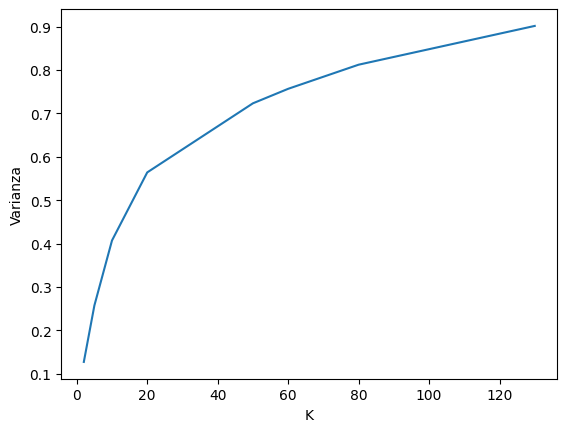

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

listak=[2,5,10,20,50,60,80,130]
listavarianza=[]
for i in range(len(listak)):
  pca1=PCA(n_components=listak[i])
  pca1.fit(X.T)
  listavarianza.append(np.sum(pca1.explained_variance_ratio_))

plt.plot(listak,listavarianza)
plt.xlabel('K')
plt.ylabel('Varianza')
plt.show()


# **Reduccion LDA con Sillhouette, Mutual Info y Rand**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
X_standard=StandardScaler().fit_transform(X)
clf=LDA(n_components=15)
Y_train=labelEncoder.fit_transform(Y_train)
X_lda=clf.fit_transform(X_standard, Y_train)

clusterlda=k_means_c(14, X_lda)
clusters=clusterlda.fit()
labels_train=assignclusters(clusterlda.centroides, X_lda)
silhouette_mt=silhouette_score(X_lda, labels_train, metric='euclidean')
print(silhouette_mt)


0.44154582662524894


Silhouette para  2 :  0.18475580609231174
Rand para  2 :  0.18009525448421754
Mutual para  2 :  0.2454218213464257
Silhouette para  3 :  0.1831181091211208
Rand para  3 :  0.6038784009317562
Mutual para  3 :  0.8250596603367766
Silhouette para  4 :  0.17679146872723941
Rand para  4 :  0.749807797822951
Mutual para  4 :  1.17578064965425
Silhouette para  5 :  0.240795286055872
Rand para  5 :  0.4237678251920303
Mutual para  5 :  0.7955671726058371
Silhouette para  6 :  0.27074294645212377
Rand para  6 :  0.6819362974727396
Mutual para  6 :  1.2491669398180085
Silhouette para  7 :  0.308792526572539
Rand para  7 :  0.7494589943998887
Mutual para  7 :  1.4637601847117783
Silhouette para  8 :  0.29952411197471374
Rand para  8 :  0.7793535273194339
Mutual para  8 :  1.5926400559027685
Silhouette para  9 :  0.32902691998450356
Rand para  9 :  0.8359877437651542
Mutual para  9 :  1.7977624084987565
Silhouette para  10 :  0.37958840991801324
Rand para  10 :  0.8749084550610873
Mutual para  10 

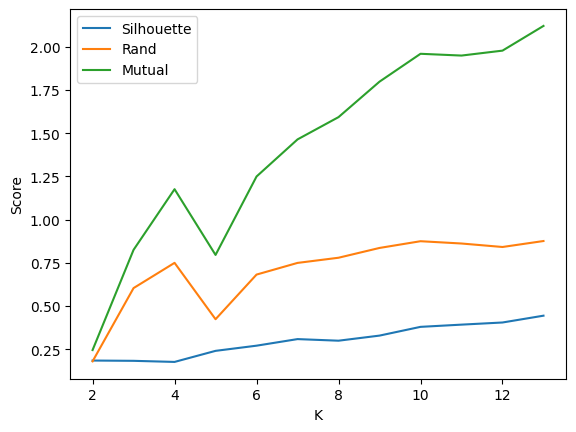

In [ ]:
lista_i=[]
lista_silhouette=[]
lista_rand=[]
lista_mutual=[]
for i in range(2,14):
  lista_i.append(i)
  clusterlda=k_means_c(i, X_lda)
  clusters=clusterlda.fit()
  labels_train=assignclusters(clusterlda.centroides, X_lda)
  silhouette_mt=silhouette_score(X_lda, labels_train, metric='euclidean')
  rand_mt=rand_score(Y_train, labels_train)
  mutual_mt=mutual_info_score(Y_train, labels_train)

  print(f"Silhouette para ", i,": ", silhouette_mt)
  print(f"Rand para ", i,": ", rand_mt)
  print(f"Mutual para ", i, ": ", mutual_mt)
  lista_silhouette.append(silhouette_mt)
  lista_rand.append(rand_mt)
  lista_mutual.append(mutual_mt)

plt.plot(lista_i,lista_silhouette, label='Silhouette')
plt.plot(lista_i,lista_rand, label='Rand')
plt.plot(lista_i,lista_mutual, label='Mutual')
plt.legend()
plt.xlabel('K')
plt.ylabel('Score')
plt.show()


También probamos con distancias como Manhattan, si bien la variación no es mucha, tiene un menor score a la distancia euclidiana

Silhouette para  2 :  0.05655930578576686
Rand para  2 :  0.18009525448421754
Mutual para  2 :  0.2454218213464257
Silhouette para  3 :  0.13126278335886324
Rand para  3 :  0.6038784009317562
Mutual para  3 :  0.8250596603367766
Silhouette para  4 :  0.1484218627400301
Rand para  4 :  0.749807797822951
Mutual para  4 :  1.17578064965425
Silhouette para  5 :  0.13169753276698093
Rand para  5 :  0.4237678251920303
Mutual para  5 :  0.7955671726058371
Silhouette para  6 :  0.1898619850200191
Rand para  6 :  0.6819362974727396
Mutual para  6 :  1.2491669398180085
Silhouette para  7 :  0.23341593850315256
Rand para  7 :  0.7494589943998887
Mutual para  7 :  1.4637601847117783
Silhouette para  8 :  0.25192922816326474
Rand para  8 :  0.7793535273194339
Mutual para  8 :  1.5926400559027685
Silhouette para  9 :  0.2952495034222801
Rand para  9 :  0.8359877437651542
Mutual para  9 :  1.7977624084987565
Silhouette para  10 :  0.34023653521203073
Rand para  10 :  0.8749084550610873
Mutual para  1

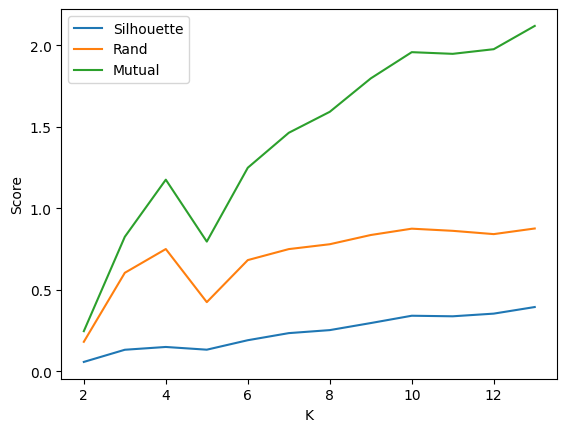

In [ ]:
lista_i=[]
lista_silhouette=[]
lista_rand=[]
lista_mutual=[]
for i in range(2,14):
  lista_i.append(i)
  clusterlda=k_means_c(i, X_lda)
  clusters=clusterlda.fit()
  labels_train=assignclusters(clusterlda.centroides, X_lda)
  silhouette_mt=silhouette_score(X_lda, labels_train, metric='manhattan')
  rand_mt=rand_score(Y_train, labels_train)
  mutual_mt=mutual_info_score(Y_train, labels_train)

  print(f"Silhouette para ", i,": ", silhouette_mt)
  print(f"Rand para ", i,": ", rand_mt)
  print(f"Mutual para ", i, ": ", mutual_mt)
  lista_silhouette.append(silhouette_mt)
  lista_rand.append(rand_mt)
  lista_mutual.append(mutual_mt)

plt.plot(lista_i,lista_silhouette, label='Silhouette')
plt.plot(lista_i,lista_rand, label='Rand')
plt.plot(lista_i,lista_mutual, label='Mutual')
plt.legend()
plt.xlabel('K')
plt.ylabel('Score')
plt.show()

# **reduccion UMAP y metricas de sillhouette, rand y mutual**

In [ ]:
from sklearn.metrics import rand_score
from sklearn.metrics import mutual_info_score

Silhouette para  2 :  0.342361
Rand para  2 :  0.25378288532157434
Mutual para  2 :  0.34940125089250446
Silhouette para  3 :  0.35760197
Rand para  3 :  0.4997340905158438
Mutual para  3 :  0.7506879495874611
Silhouette para  4 :  0.43726075
Rand para  4 :  0.5999763430020542
Mutual para  4 :  0.9847640682427089
Silhouette para  5 :  0.4410559
Rand para  5 :  0.5782951573761412
Mutual para  5 :  1.0448539031702189
Silhouette para  6 :  0.5502729
Rand para  6 :  0.7688106670778453
Mutual para  6 :  1.4532150467559506
Silhouette para  7 :  0.58498347
Rand para  7 :  0.86088674284817
Mutual para  7 :  1.7407643569786317
Silhouette para  8 :  0.63185084
Rand para  8 :  0.8780838377352413
Mutual para  8 :  1.8598110944006514
Silhouette para  9 :  0.6871715
Rand para  9 :  0.8891936369006912
Mutual para  9 :  1.9584091745263397
Silhouette para  10 :  0.7117548
Rand para  10 :  0.9016244920833272
Mutual para  10 :  2.0656868767618946
Silhouette para  11 :  0.7435344
Rand para  11 :  0.938672

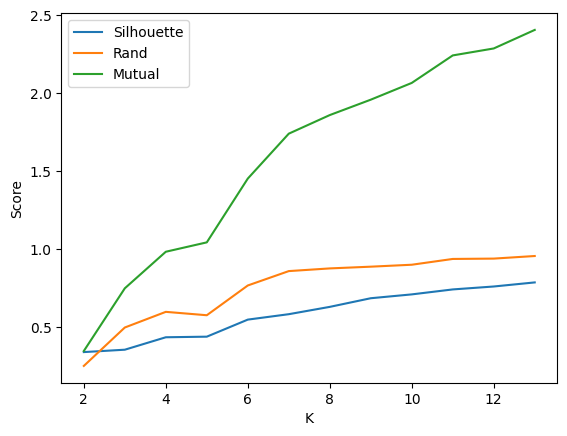

In [ ]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

umap_red = umap.UMAP(n_components=130)
X_umap = umap_red.fit_transform(X)
lista_i=[]
lista_silhouette=[]
lista_rand=[]
lista_mutual=[]
for i in range(2,14):
  lista_i.append(i)
  clusterumap=k_means_c(i, X_umap)
  clusters=clusterumap.fit()
  labels_train=assignclusters(clusterumap.centroides, X_umap)
  silhouette_mt=silhouette_score(X_umap, labels_train, metric='euclidean')
  rand_mt=rand_score(Y_train, labels_train)
  mutual_mt=mutual_info_score(Y_train, labels_train)

  print(f"Silhouette para ", i,": ", silhouette_mt)
  print(f"Rand para ", i,": ", rand_mt)
  print(f"Mutual para ", i, ": ", mutual_mt)
  lista_silhouette.append(silhouette_mt)
  lista_rand.append(rand_mt)
  lista_mutual.append(mutual_mt)

plt.plot(lista_i,lista_silhouette, label='Silhouette')
plt.plot(lista_i,lista_rand, label='Rand')
plt.plot(lista_i,lista_mutual, label='Mutual')
plt.legend()
plt.xlabel('K')
plt.ylabel('Score')
plt.show()


**Experimento con librería para estandarizar datos.  
Reducción a prueba: UMAP**

In [ ]:
def plot_2d(X, cabecera, c = None):

    if c is not None:
        plt.scatter(X[:, 0],X[:, 1], c=c, cmap='viridis')
    else:
      plt.scatter(X[:, 0],X[:, 1])
    plt.title(cabecera)

In [ ]:
from sklearn.preprocessing import PowerTransformer

objectpt = PowerTransformer()
objectpt.fit(X)
X = objectpt.transform(X)

umap_red = umap.UMAP(n_components=3)
X_umap = umap_red.fit_transform(X)

In [ ]:
#ejecutar cuando exista vec es decir que se haya agrupado por kmeans, nuestra implementaicon retorna un dic y vec que almacena el cluster por id de feature vector de cada video
plot_2d(X_umap,"k-means con estandarización POWERSCALER y reducción UMAP",vec)